In [1]:
import os
from PIL import Image
import pandas as pd
import numpy as np
import argparse
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets

In [2]:
USE_CUDA = True if torch.cuda.is_available() else False
DEVICE = 'cuda:0' if USE_CUDA else 'cpu'

In [3]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

In [4]:
parser = argparse.ArgumentParser()
parser.add_argument('--n_epoch', type=int, default=50)
parser.add_argument('--batch_size', type=int, default=2)
parser.add_argument('--lr', type=float, default=0.001)
args = parser.parse_args('')

In [5]:
data_dir = '../data/ISBI2012EM/'
ckpt_dir = './checkpoint'
log_dir = './log'

In [6]:
class Dataset(Dataset):
  def __init__(self, data_dir, transform=None):
    self.data_dir = data_dir
    self.transform = transform

    lst_data = os.listdir(self.data_dir)

    lst_label = [f for f in lst_data if f.startswith('label')]
    lst_input = [f for f in lst_data if f.startswith('input')]

    lst_label.sort()
    lst_input.sort()

    self.lst_label = lst_label
    self.lst_input = lst_input

  def __len__(self):
    return len(self.lst_label)
  
  def __getitem__(self, index):
    label_ = np.load(os.path.join(self.data_dir, self.lst_label[index]))
    input_ = np.load(os.path.join(self.data_dir, self.lst_input[index]))

    if label_.ndim == 2:
      label_ = label_[:, :, np.newaxis]

    if input_.ndim == 2:
      input_ = input_[:, :, np.newaxis]


    data = {'input':input_, 'label':label_}

    if self.transform:
      data = self.transform(data)
    

    return data

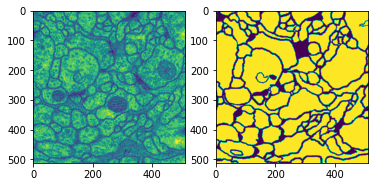

In [7]:
dataset_train = Dataset(data_dir=os.path.join(data_dir, 'train'))

data = dataset_train.__getitem__(0)

input_ = data['input']
label_ = data['label']

plt.subplot(121)
plt.imshow(input_.squeeze())

plt.subplot(122)
plt.imshow(label_.squeeze())

plt.show()

In [8]:
class ToTensor(object):
  def __call__(self, data):
    label_, input_ = data['label'], data['input']

    label_ = label_ / 255.0
    input_ = input_ / 255.0
    
    label_ = label_.transpose((2, 0, 1)).astype(np.float32)
    input_ = input_.transpose((2, 0, 1)).astype(np.float32)

    data = {'label': torch.from_numpy(label_), 'input': torch.from_numpy(input_)}

    return data


class Normalization(object):
  def __init__(self, mean=0.5, std=0.5):
    self.mean = mean
    self.std = std

  def __call__(self, data):
    label_, input_ = data['label'], data['input']

    input_ = (input_ - self.mean) / self.std

    data = {'label': label_, 'input': input_}

    return data

class RandomFlip(object):
  def __call__(self, data):
    label_, input_ = data['label'], data['input']

    if np.random.rand() > 0.5:
      label_ = np.fliplr(label_)
      input_ = np.fliplr(input_)

    if np.random.rand() > 0.5:
      label_ = np.flipud(label_)
      input_ = np.flipud(input_)
      
    data = {'label': label_, 'input': input_}

    return data

In [9]:
transform = transforms.Compose([
  RandomFlip(),  
  ToTensor(),
  Normalization()
])

dataset_train = Dataset(data_dir=os.path.join(data_dir, 'train'), transform=transform)

In [10]:
data = dataset_train.__getitem__(0)

input_ = data['input']
label_ = data['label']

print(input_.shape)

torch.Size([1, 512, 512])


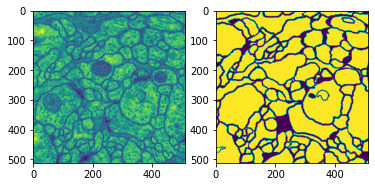

In [11]:
plt.subplot(121)
plt.imshow(input_.squeeze())

plt.subplot(122)
plt.imshow(label_.squeeze())

plt.show()

In [12]:
class UNet(nn.Module):
  def __init__(self,):
    super().__init__()

    # conv + batch norm + relu
    def CBR2d(in_channels, out_channels):
      layers = [
        nn.Conv2d(
          in_channels,
          out_channels, 
          kernel_size=3,
          stride=1,
          padding=1,
          bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
      ]
      
      return layers

    # contracting path
    self.down_conv1 = nn.Sequential(*CBR2d(1, 64), *CBR2d(64, 64))
    self.down_scale1 = nn.MaxPool2d(kernel_size=2)
    self.down_conv2 = nn.Sequential(*CBR2d(64, 128), *CBR2d(128, 128))
    self.down_scale2 = nn.MaxPool2d(kernel_size=2)
    self.down_conv3 = nn.Sequential(*CBR2d(128, 256), *CBR2d(256, 256))
    self.down_scale3 = nn.MaxPool2d(kernel_size=2)
    self.down_conv4 = nn.Sequential(*CBR2d(256, 512), *CBR2d(512, 512))
    self.down_scale4 = nn.MaxPool2d(kernel_size=2)
    self.down_conv5 = nn.Sequential(*CBR2d(512, 1024))

    # expansive path
    self.up_conv5 = nn.Sequential(*CBR2d(1024, 512))
    self.up_scale4 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
    self.up_conv4 = nn.Sequential(*CBR2d(1024, 512), *CBR2d(512, 256))
    self.up_scale3 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2)
    self.up_conv3 = nn.Sequential(*CBR2d(512, 256), *CBR2d(256, 128))
    self.up_scale2 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)
    self.up_conv2 = nn.Sequential(*CBR2d(256, 128), *CBR2d(128, 64))
    self.up_scale1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
    self.up_conv1 = nn.Sequential(*CBR2d(128, 64), *CBR2d(64, 64))

    self.fc = nn.Conv2d(64, 1, kernel_size=1, stride=1, padding=0)


  def forward(self, x):
    # contracting path
    x1 = self.down_conv1(x)
    pool1 = self.down_scale1(x1)
    x2 = self.down_conv2(pool1)
    pool2 = self.down_scale2(x2)
    x3 = self.down_conv3(pool2)
    pool3 = self.down_scale3(x3)
    x4 = self.down_conv4(pool3)
    pool4 = self.down_scale4(x4)
    x5 = self.down_conv5(pool4)
    # expansive path
    _x5 = self.up_conv5(x5)
    unpool4 = self.up_scale4(_x5)
    x_concat = torch.cat((unpool4, x4), dim=1) # 채널 방향으로 붙이기
    _x4 = self.up_conv4(x_concat)
    unpool3 = self.up_scale3(_x4)
    x_concat = torch.cat((unpool3, x3), dim=1)
    _x3 = self.up_conv3(x_concat)
    unpool2 = self.up_scale2(_x3)
    x_concat = torch.cat((unpool2, x2), dim=1)
    _x2 = self.up_conv2(x_concat)
    unpool1 = self.up_scale1(_x2)
    x_concat = torch.cat((unpool1, x1), dim=1)
    _x1 = self.up_conv1(x_concat)
    x = self.fc(_x1)
    return x


In [13]:
dataset_train = Dataset(data_dir=os.path.join(data_dir, 'train'), transform=transform)
loader_train = DataLoader(dataset_train, batch_size=args.batch_size, shuffle=True, num_workers=0)

dataset_val = Dataset(data_dir=os.path.join(data_dir, 'val'), transform=transform)
loader_val = DataLoader(dataset_val, batch_size=args.batch_size, shuffle=False, num_workers=0)

In [14]:
net = UNet().to(DEVICE)

fn_loss = nn.BCEWithLogitsLoss().to(DEVICE)

optimizer = optim.Adam(net.parameters(), lr=args.lr)

num_data_train = len(dataset_train)
num_data_val = len(dataset_val)
num_batch_train = np.ceil(num_data_train / args.batch_size)
num_batch_val = np.ceil(num_data_val / args.batch_size)

fn_to_numpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x, mean, std: (x * std) + mean
fn_class = lambda x: 1.0 * (x > 0.5)

In [16]:
writer_train = SummaryWriter(log_dir=os.path.join(log_dir, 'train'))
writer_val = SummaryWriter(log_dir=os.path.join(log_dir, 'val'))

In [17]:
def save_net(ckpt_dir, net, optim, epoch):
  if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

  torch.save({'net': net.state_dict(), 'optim': optim.state_dict()}, f'./{ckpt_dir}/model_epoch{epoch}.pth')


def load_net(ckpt_dir, net, optim):
  if not os.path.exists(ckpt_dir):
    epoch = 0
    return net, optim, epoch

  ckpt_lst = os.listdir(ckpt_dir)
  ckpt_lst.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

  dict_model = torch.load(f'./{ckpt_dir}/{ckpt_lst[-1]}')

  net.load_state_dict(dict_model['net'])
  optim.load_state_dict(dict_model['optim'])
  epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth'))

  return net, optim, epoch

In [18]:
st_epoch = 0

for epoch in range(st_epoch+1, args.n_epoch+1):
  net.train()

  loss_arr = []

  for batch, data in enumerate(loader_train, 1):
    label_ = data['label'].to(DEVICE)
    input_ = data['input'].to(DEVICE)

    output = net(input_)
    loss = fn_loss(output, label_)

    optimizer.zero_grad()
    
    loss.backward()

    optimizer.step()

    loss_arr += [loss.item()]

    print(f'train: epoch {epoch:04d}/{args.n_epoch} | batch {batch}/{int(num_batch_train):04d} | loss {np.mean(loss_arr):.4f}')
 
    label_ = fn_to_numpy(label_)
    input_ = fn_to_numpy(fn_denorm(input_, mean=0.5, std=0.5))
    output = fn_to_numpy(fn_class(output))

    writer_train.add_image('label', label_, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
    writer_train.add_image('input', input_, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
    writer_train.add_image('output', output, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')

  writer_train.add_scalar('loss', np.mean(loss_arr), epoch)

  with torch.no_grad():
    net.eval()
    loss_arr = []

    for batch, data in enumerate(loader_val, 1):

      label_ = data['label'].to(DEVICE)
      input_ = data['input'].to(DEVICE)

      output = net(input_)

      loss = fn_loss(output, label_)

      loss_arr += [loss.item()]

      print(f'val : {epoch:04d}/{args.n_epoch} | batch {batch}/{int(num_batch_val):04d} | loss {np.mean(loss_arr):.4f}')

      label_ = fn_to_numpy(label_)
      input_ = fn_to_numpy(fn_denorm(input_, mean=0.5, std=0.5))
      output = fn_to_numpy(fn_class(output))

      writer_val.add_image('label', label_, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
      writer_val.add_image('input', input_, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
      writer_val.add_image('output', output, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
  
  writer_val.add_scalar('loss', np.mean(loss_arr), epoch)

  if epoch % 5 == 0:
    save_net(ckpt_dir, net, optimizer, epoch)

writer_train.close()
writer_val.close()

train: epoch 0001/50 | batch 1/0012 | loss 0.7208
train: epoch 0001/50 | batch 2/0012 | loss 0.6460
train: epoch 0001/50 | batch 3/0012 | loss 0.6000
train: epoch 0001/50 | batch 4/0012 | loss 0.5891
train: epoch 0001/50 | batch 5/0012 | loss 0.5650
train: epoch 0001/50 | batch 6/0012 | loss 0.5501
train: epoch 0001/50 | batch 7/0012 | loss 0.5331
train: epoch 0001/50 | batch 8/0012 | loss 0.5183
train: epoch 0001/50 | batch 9/0012 | loss 0.5083
train: epoch 0001/50 | batch 10/0012 | loss 0.4964
train: epoch 0001/50 | batch 11/0012 | loss 0.4872
train: epoch 0001/50 | batch 12/0012 | loss 0.4811
val : 0001/50 | batch 1/0002 | loss 0.6363
val : 0001/50 | batch 2/0002 | loss 0.6299
train: epoch 0002/50 | batch 1/0012 | loss 0.3907
train: epoch 0002/50 | batch 2/0012 | loss 0.3726
train: epoch 0002/50 | batch 3/0012 | loss 0.3686
train: epoch 0002/50 | batch 4/0012 | loss 0.3633
train: epoch 0002/50 | batch 5/0012 | loss 0.3611
train: epoch 0002/50 | batch 6/0012 | loss 0.3568
train: epoc